# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster from the Freie Universität Berlin.

_Note_:
- The notebook will run using the results stored in the `output` folder. They were generated using the following:
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --string-encoding smiles --aug-strategy-train augmentation_with_reduced_duplication --aug-strategy-test augmentation_with_reduced_duplication --aug-nb-train 70 --aug-nb-test 70 --ml-model CONV1D --eval-strategy True
```
- a `figures` folder will be created in which the images are saved.

📝 Have a look at the [README](https://github.com/volkamerlab/maxsmi/blob/main/README.md) page for more details.

## Ensemble learning results
Here we load the data which contains relevant information if there was augmentation on the test set, such as
- the absolute error between the true value and the average value
- confidence of the prediction: is the standard deviation low or high?

This data represents _only_ the test set (20%) and not the full data (100%).

### Goal
The aim of this notebook is to look at the best models which use duplication of SMILES (with and with reduced) in training and testing and analyse whether a model could learn inherent symmetry of compounds.

In [13]:
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import PandasTools, Draw

from utils_analysis import load_results
from utils_smiles import get_num_heavy_atoms

In [2]:
# Make a folder for output figures
os.makedirs("figures", exist_ok=True)

## Dataset
We consider the following datasets:

- ESOL
- lipophilicity

_Note_: we do not look at the free_solv data, since the best strategy for this task is augmentation without duplication, which is not the focus of this study, but rather augmentation with or with reduced duplication. 

Comment/uncomment the dataset of choice in the cell below.

In [16]:
TASK = "lipophilicity"
# TASK = "ESOL"
TASK = "free_solv"

## Best models
Retrieve best models for the ESOL and the lipophilicity data sets.

In [17]:
if TASK == "ESOL":
    STRING_ENCODING = "smiles"
    TRAIN_AUGMENTATION = 70
    TEST_AUGMENTATION = 70
    AUGMENTATION_STRATEGY_TRAIN = "augmentation_with_reduced_duplication"
    AUGMENTATION_STRATEGY_TEST = "augmentation_with_reduced_duplication"
    ML_MODEL = "CONV1D"

elif TASK == "lipophilicity":
    STRING_ENCODING = "smiles"
    TRAIN_AUGMENTATION = 80
    TEST_AUGMENTATION = 80
    AUGMENTATION_STRATEGY_TRAIN = "augmentation_with_duplication"
    AUGMENTATION_STRATEGY_TEST = "augmentation_with_duplication"
    ML_MODEL = "CONV1D"
    
elif TASK == "free_solv":
    STRING_ENCODING = "smiles"
    TRAIN_AUGMENTATION = 70
    TEST_AUGMENTATION = 70
    AUGMENTATION_STRATEGY_TRAIN = "augmentation_without_duplication"
    AUGMENTATION_STRATEGY_TEST = "augmentation_without_duplication"
    ML_MODEL = "CONV1D"

## Load data

In [18]:
test_data = load_results(TASK,
                         AUGMENTATION_STRATEGY_TRAIN,
                         TRAIN_AUGMENTATION,
                         AUGMENTATION_STRATEGY_TEST,
                         TEST_AUGMENTATION,
                         ML_MODEL,
                         STRING_ENCODING,
                         True)
test_data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
394,-9.40,O=C(O)c1cc(-c2ccc(F)cc2F)ccc1O,"[C(O)(c1c(O)ccc(c1)-c1c(F)cc(F)cc1)=O, c1(cc(-...","[C(O)(c1c(O)ccc(c1)-c1c(F)cc(F)cc1)=O, c1(cc(-...",-9.044036,0.864539
268,1.23,C1CCCCC1,[C1CCCCC1],[C1CCCCC1],0.487129,0.000000
364,-9.28,CS(C)=O,"[O=S(C)C, CS(C)=O, CS(=O)C, S(C)(=O)C, S(C)(C)...","[O=S(C)C, CS(C)=O, CS(=O)C, S(C)(=O)C, S(C)(C)...",-5.858472,0.277142
612,-5.73,O=[N+]([O-])OCCO[N+](=O)[O-],"[C(CO[N+](=O)[O-])O[N+]([O-])=O, O=[N+]([O-])O...","[C(CO[N+](=O)[O-])O[N+]([O-])=O, O=[N+]([O-])O...",-5.244985,0.529231
370,0.10,ClC(Cl)=C(Cl)Cl,"[C(Cl)(=C(Cl)Cl)Cl, ClC(Cl)=C(Cl)Cl, C(=C(Cl)C...","[C(L)(=C(L)L)L, LC(L)=C(L)L, C(=C(L)L)(L)L, LC...",-0.890657,0.397646


In [19]:
test_data["std_prediction"].max()

2.4536542892456055

In [20]:
std_dev_threshold = 0.4

In [21]:
high_std_dev = test_data[test_data["std_prediction"] >= std_dev_threshold ]

In [22]:
low_std_dev = test_data[test_data["std_prediction"] < std_dev_threshold ]

In [23]:
high_std_dev.shape, low_std_dev.shape

((82, 6), (47, 6))

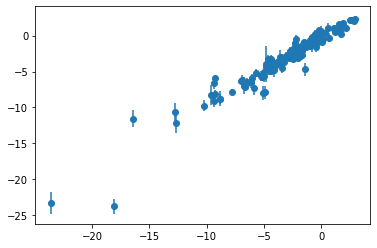

In [25]:
plt.errorbar(test_data["target"], test_data["average_prediction"], yerr=test_data["std_prediction"], fmt='o')#, ecolor=None, elinewidth=None, capsize=None, barsabove=False,)
plt.show()

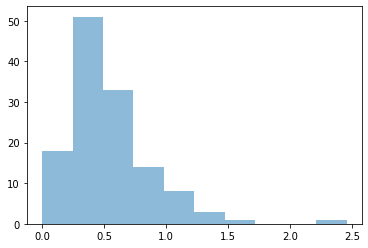

In [26]:
plt.hist(test_data["std_prediction"], alpha=0.5)
plt.show()

## Load the canonical counterpart

In [ ]:
test_data_canonical = load_results(TASK,
                                   "no_augmentation",
                                   0,
                                   "no_augmentation",
                                   0,
                                   ML_MODEL,
                                   STRING_ENCODING,
                                   True)
test_data_canonical.head()

Merge the tables into one dataframe.

In [ ]:
test_data_canonical = test_data_canonical.rename(columns={"average_\
prediction": "canonical_prediction"})

In [ ]:
data = pd.concat([test_data, test_data_canonical["canonical_prediction"]],
                 axis=1)
data.head()

### Size of molecules
Compute the number of heavy atoms in each molecule.

In [ ]:
data["num_heavy_atoms"] = data["canonical_\
smiles"].apply(get_num_heavy_atoms)

## Difference in prediction error with and without augmentation

In [ ]:
data["average_error"] = (data["target"] - data["average_prediction"]).abs()
data["canonical_error"] = (data["target"] - data["canonical_prediction"]).abs()
data.head()

In [ ]:
data["errors_difference"] = (data["average_error"] -
                             data["canonical_error"]).abs()

In [ ]:
data = data[data["average_error"] < data["canonical_error"]]

In [ ]:
for index in data.index:
    nb_unique_smiles = len(Counter(data.loc[index]["augmented_smiles"]))
    data.loc[index,
             "nb_unique_smiles"] = nb_unique_smiles

data["nb_unique_smiles"] = data["nb_unique_smiles"].astype("int32")

In [ ]:
data.head(2)

In [ ]:
data = data[data["num_heavy_atoms"] < 15]
data = data.sort_values(by="errors_difference", ascending=False)[0:4]
data = data[["canonical_smiles",
             "target",
             "canonical_prediction",
             "average_prediction",
             "std_prediction",
             "canonical_error",
             "average_error",
             ]]

## Draw molecules

In [ ]:
for index in data.index:
    canonical_smile = data.loc[index]["canonical_smiles"]
    mol = Chem.MolFromSmiles(canonical_smile)
    PandasTools.AddMoleculeColumnToFrame(data,
                                         smilesCol="canonical_smiles")
data = data.rename(columns={"ROMol": "graph"})

In [ ]:
df = data.style.\
    set_caption(f"Data: {TASK}").\
    format({"target": "{:.2f}",
            "prediction": "{:.2f}",
            "average_prediction": "{:.2f}",
            "std_prediction": "{:.2f}",
            "canonical_error": "{:.2f}",
            "average_error": "{:.2f}",
            "errors_difference": "{:.2f}"})
df

### Export molecules

In [ ]:
def export_rdkit_images(task):
    """
    Export molecular graph for interesting molecules.
    """
    indices = []
    if task == "ESOL":
        indices = [1063, 971]
    elif task == "lipophilicity":
        indices = [1701]
    for ind in indices:
        canonical_smile = df.data.canonical_smiles[ind]
        molecule = Chem.MolFromSmiles(canonical_smile)
        Draw.MolToFile(molecule, f"figures/{task}_{canonical_smile}.png")

In [ ]:
export_rdkit_images(TASK)